1. Lookback window 사이즈를 다르게 주자

2. 리벨런싱 주기를 다르게

3. max_ratio를 다르게

4. Shrinkage Method를 다르게

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ray

from optimize_multi.object_function import * 
from optimize_multi.optimizer_v2 import run_optimizer
from optimize_multi.backtest import simulate_strategy

from ryu_tool.mytool import draw_return_result, print_statistics, run_alpha_regression

2023-05-19 19:59:53,418	INFO worker.py:1625 -- Started a local Ray instance.


In [5]:
# 필요한 데이터 불러오기
price = pd.read_pickle("Data/allstock_adj.pickle")
rtn = price.pct_change(fill_method=None)

spx_mask = pd.read_pickle("Data/spx_mask.pickle")

# ETF Data
etf = pd.read_csv("Data/ETF.csv", index_col=0, parse_dates=True)
rtn_etf = etf.dropna().pct_change(fill_method=None).fillna(0)

In [7]:
# Ray를 사용하기 위해 Ray데이터 생성
rtn_ray = ray.put(rtn)
mask_ray = ray.put(spx_mask)

etf_ray = ray.put(rtn_etf)

In [8]:
# S&P500 마켓 데이터 (결과 비교를 위해)
spx = pd.read_csv("Data/spx_hist.csv", 
                  index_col=0,
                  parse_dates=True).pct_change(fill_method=None)

# Investing.com에서 받아와서 그런지 Timestamp에 문제가 있다
problem = [pd.Timestamp('2021-07-03 00:00:00'),
           pd.Timestamp('2021-07-04 00:00:00'),
           pd.Timestamp('2021-07-05 00:00:00'),
           pd.Timestamp('2021-08-07 00:00:00'),
           pd.Timestamp('2021-08-08 00:00:00')]

spx = spx.drop(problem)

In [10]:
look_back_list = [60, 120, 180, 240, 300, 365]
look_back_list2 = [90, 110, 130, 150, 170]
args_lst = [0.1, 1, 3, 5, 10, 20]

In [ ]:
# ETF Optimizing
futures = [run_optimizer.remote(obj_function=obj_sharpe, 
                                rtn_df=etf_ray,
                                spx_mask="None",
                                start_year="2006",
                                end_year="2023",
                                rebalancing="Q",
                                look_back_size=arg,
                                max_ratio=1,
                                shrinkage_method="linear",
                                arg="None")  for arg in look_back_list]
result = ray.get(futures)

RayTaskError(UFuncTypeError): [36mray::run_optimizer()[39m (pid=5664, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 877, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 881, in ray._raylet.execute_task
  File "c:\Jehyeon\Portfolio-Optimization-2023-FR-Project-\optimize_multi\optimizer_v2.py", line 66, in run_optimizer
    shrinked_corr_matrix = shrink[shrinkage_method](corr_matrix = corr_matrix, arg=arg) # Corr_matrix를 축소
  File "c:\Jehyeon\Portfolio-Optimization-2023-FR-Project-\optimize_multi\shrinkage_method.py", line 20, in linear_shrinkage
    return  alpha * np.identity(corr_matrix.shape[0]) + (1-alpha) * corr_matrix
numpy.core._exceptions._UFuncNoLoopError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('float64')) -> None

  0%|          | 0/68 [00:00<?, ?it/s] [repeated 12x across cluster]
2023-05-19 20:25:58,462	ERROR worker.py:408 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::run_optimizer() (pid=3632, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 877, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 881, in ray._raylet.execute_task
  File "c:\Jehyeon\Portfolio-Optimization-2023-FR-Project-\optimize_multi\optimizer_v2.py", line 66, in run_optimizer
    shrinked_corr_matrix = shrink[shrinkage_method](corr_matrix = corr_matrix, arg=arg) # Corr_matrix를 축소
  File "c:\Jehyeon\Portfolio-Optimization-2023-FR-Project-\optimize_multi\shrinkage_method.py", line 20, in linear_shrinkage
    return  alpha * np.identity(corr_matrix.shape[0]) + (1-alpha) * corr_matrix
numpy.core._exceptions._UFuncNoLoopError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('float64')) -> None
2023-05-19 20:25:58,466	ERROR worker.py:408 -- Un

In [33]:
futures = [run_optimizer.remote(obj_function=obj_variance, 
                                rtn_df=rtn_ray,
                                spx_mask=mask_ray,
                                start_year="2006",
                                end_year="2023",
                                rebalancing="Q",
                                look_back_size=300,
                                max_ratio=1,
                                shrinkage_method="clipping",
                                arg=arg)  for arg in args_lst]
result = ray.get(futures)

100%|██████████| 68/68 [17:57<00:00, 15.85s/it] [repeated 3x across cluster]


100%|██████████| 68/68 [18:05<00:00, 15.96s/it] [repeated 3x across cluster]


In [25]:
result_dict = {}
weight_dict = {}

for i, arg in enumerate(look_back_list):
    rt, weig = simulate_strategy(result[i], rtn_etf, fee_rate=0)
    result_dict[f"Minimun Variance Portfolio / Shrinkage=Eigenvalue Clipping (k={arg}) / Look Back 300 days"] = rt
    weight_dict[str(arg)] = weig

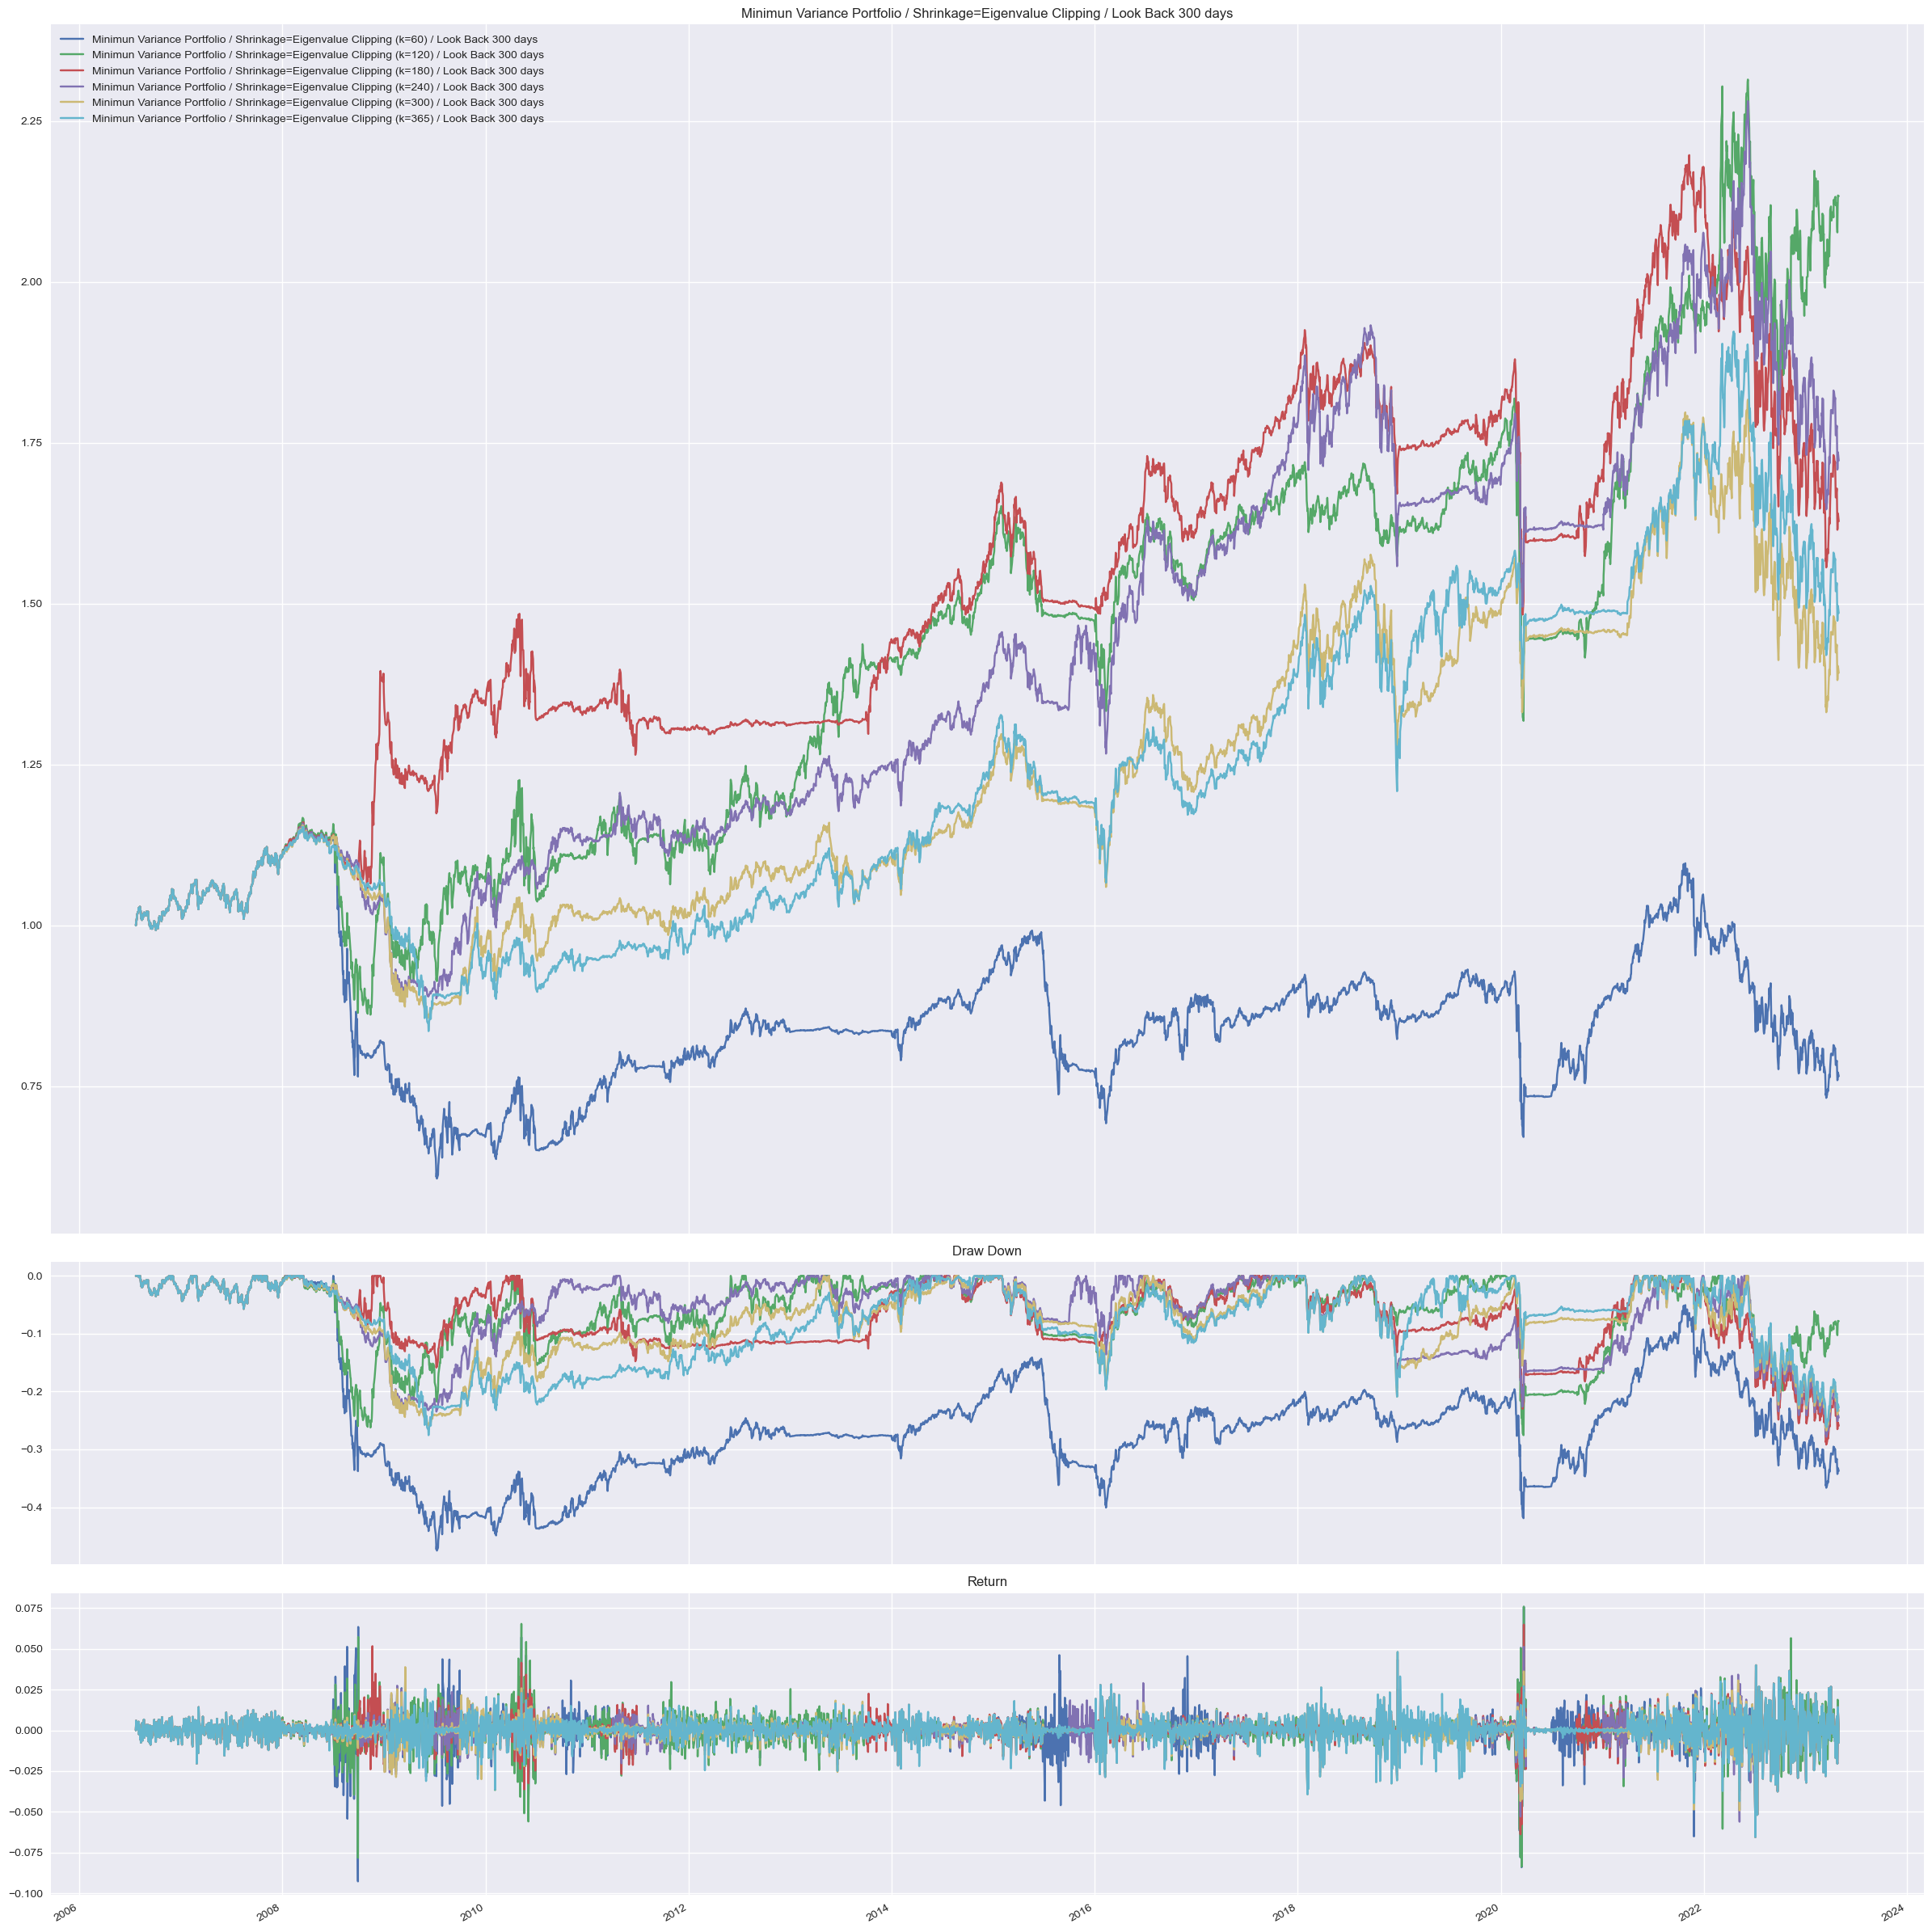

In [26]:
draw_return_result(result_dict,
                   one_plot=True,
                   title="Minimun Variance Portfolio / Shrinkage=Eigenvalue Clipping / Look Back 300 days")

In [27]:
stats = print_statistics(result_dict)
stats.columns = [f"k={day}" for day in args_lst]
stats

,k=0.1,k=1,k=3,k=5,k=10,k=20
CAGR,-0.016000,0.045500,0.028900,0.032400,0.019500,0.023400
Mean,-0.007890,0.079310,0.050680,0.056730,0.038090,0.043830
STD,0.173887,0.165754,0.130501,0.139176,0.137302,0.138401
MDD,0.475000,0.275000,0.292000,0.278000,0.267000,0.275000
Sharpe,-0.045374,0.478481,0.388350,0.407613,0.277419,0.316688


In [22]:
weight_dict.keys()

dict_keys(['60', '120', '180', '240', '300', '365'])

Text(0.5, 1.0, 'Minimum Variance / Q / max_ratio=1 / shrinkage=Eigenvalue Clipping (k=1) / Look Back Window = 300 days')

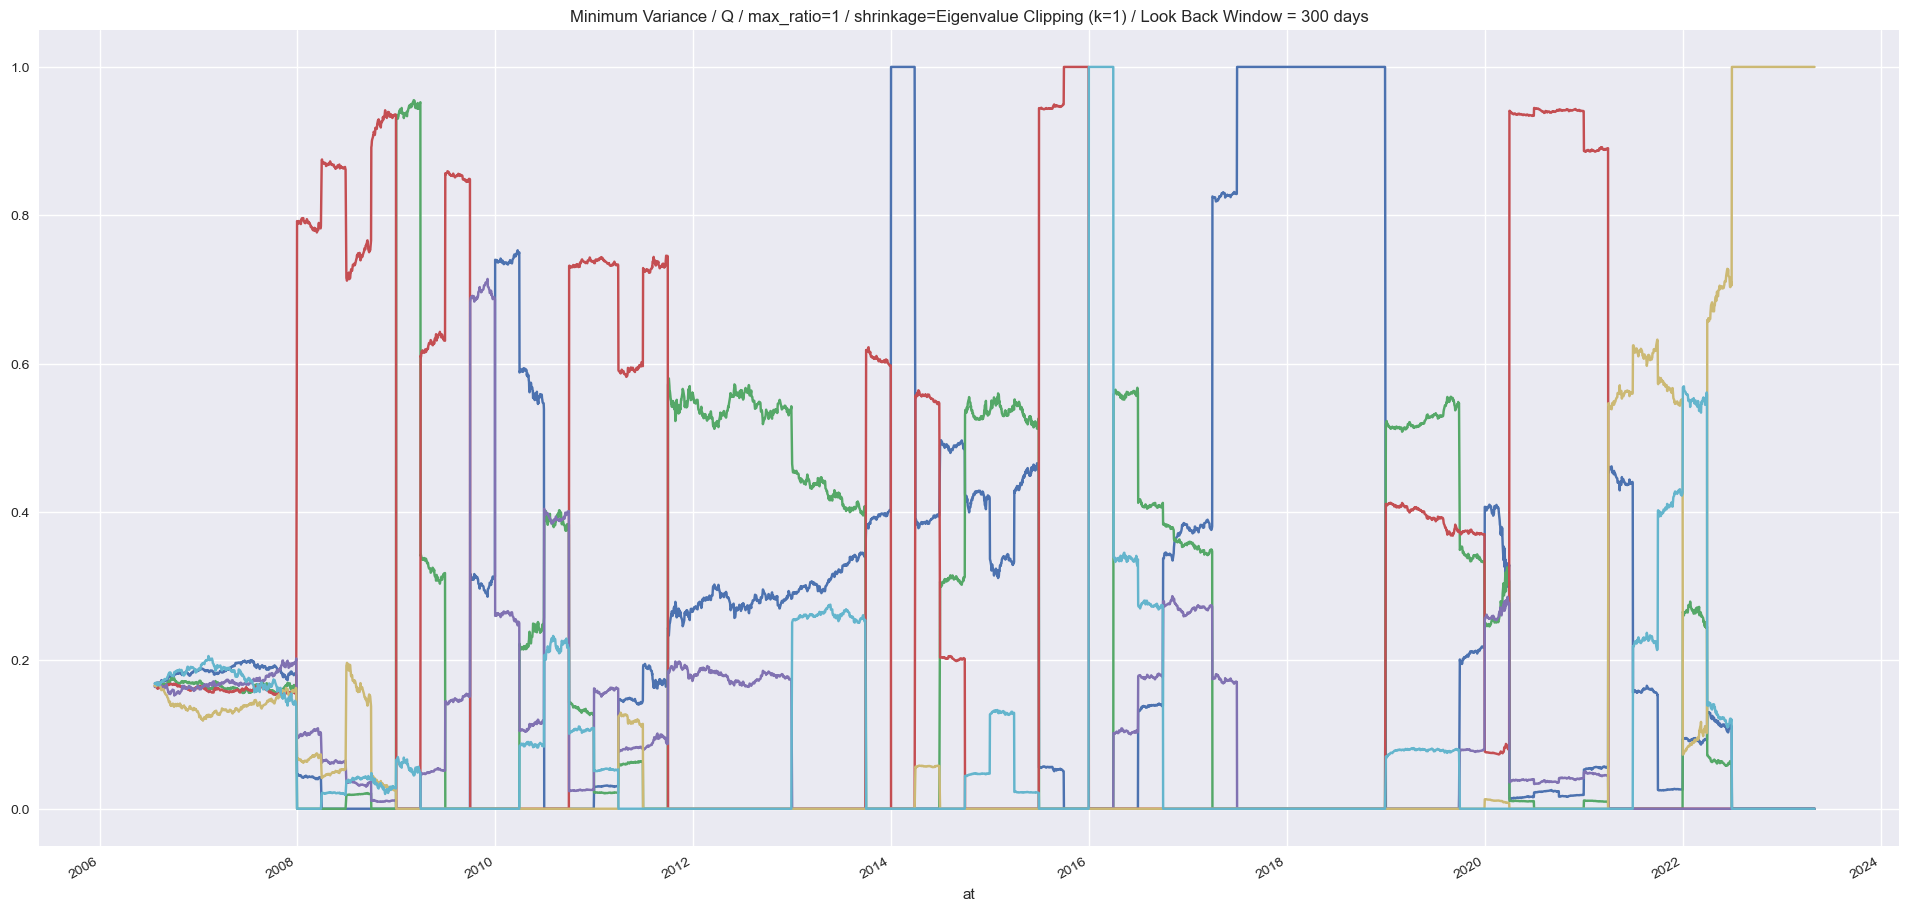

In [28]:
weight_dict["300"].plot(figsize=(24,12),
                        legend=False)
plt.title("Minimum Variance / Q / max_ratio=1 / shrinkage=Eigenvalue Clipping (k=1) / Look Back Window = 300 days")

In [ ]:
portfolio = result_dict["Eigenvalue Clipping / Alpha=5 / Look Back 150 days"]
spx_sample = spx.loc[portfolio.index[0]:]["Price"] # Series로 변경

draw_return_result({"Eigenvalue Clipping / Alpha=5 / Look Back 150 days":portfolio,
                    "S&P500": spx_sample},
                   one_plot=True)

In [ ]:
st = print_statistics({"Eigenvalue Clipping / Alpha=5 / Look Back 150 days":portfolio,
                       "S&P500": spx_sample})
st.columns = ["Eigenvalue Clipping","S&P500"]
st

In [ ]:
run_alpha_regression({"Eigenvalue Clipping":portfolio.iloc[1:]},
                     mkt_rtn=spx_sample)